In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime
import ipaddress
import os

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Create results directory
if not os.path.exists('../results'):
    os.makedirs('../results')

In [2]:
# Load datasets
fraud_data = pd.read_csv('../Data/Fraud_Data.csv')
ip_country = pd.read_csv('../Data/IpAddress_to_Country.csv')
creditcard_data = pd.read_csv('../Data/creditcard.csv')

print("Dataset shapes:")
print(f"Fraud Data: {fraud_data.shape}")
print(f"IP to Country: {ip_country.shape}")
print(f"Credit Card Data: {creditcard_data.shape}")

Dataset shapes:
Fraud Data: (151112, 11)
IP to Country: (138846, 3)
Credit Card Data: (284807, 31)


In [3]:
# Display basic information about fraud data
print("=== FRAUD DATA OVERVIEW ===")
print(fraud_data.info())
print("\nFirst 5 rows:")
fraud_data.head()

=== FRAUD DATA OVERVIEW ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB
None

First 5 rows:


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
# Check for missing values
print("=== MISSING VALUES ANALYSIS ===")
print("\nFraud Data Missing Values:")
fraud_missing = fraud_data.isnull().sum()
fraud_missing_pct = (fraud_missing / len(fraud_data)) * 100
missing_df = pd.DataFrame({
    'Missing Count': fraud_missing,
    'Missing Percentage': fraud_missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

# Handle missing values (if any)
if fraud_missing.sum() > 0:
    fraud_data.fillna({
        'source': fraud_data['source'].mode()[0],
        'browser': fraud_data['browser'].mode()[0],
        'sex': fraud_data['sex'].mode()[0],
        'age': fraud_data['age'].median(),
        'purchase_value': fraud_data['purchase_value'].median()
    }, inplace=True)
print("\nMissing values handled for Fraud Data.")

=== MISSING VALUES ANALYSIS ===

Fraud Data Missing Values:
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []

Missing values handled for Fraud Data.


=== CLASS DISTRIBUTION ANALYSIS ===
Fraud Data Class Distribution:
Legitimate (0): 136,961 (90.64%)
Fraudulent (1): 14,151 (9.36%)
Imbalance Ratio: 9.7:1


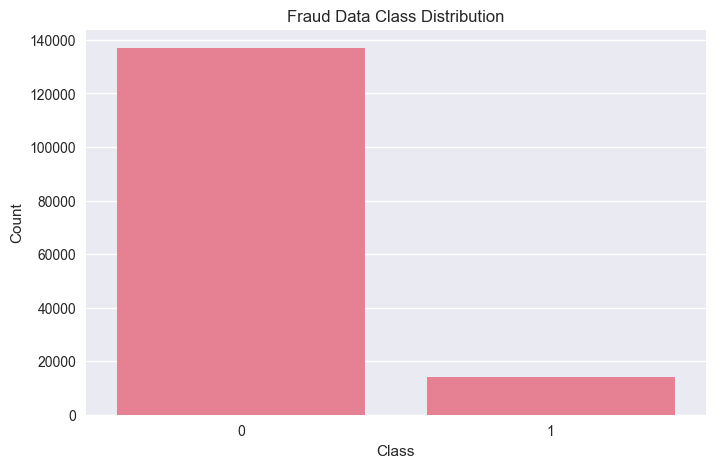

In [5]:
# Analyze class distribution
print("=== CLASS DISTRIBUTION ANALYSIS ===")

# Fraud data class distribution
fraud_class_dist = fraud_data['class'].value_counts()
fraud_class_pct = fraud_data['class'].value_counts(normalize=True) * 100

print("Fraud Data Class Distribution:")
print(f"Legitimate (0): {fraud_class_dist[0]:,} ({fraud_class_pct[0]:.2f}%)")
print(f"Fraudulent (1): {fraud_class_dist[1]:,} ({fraud_class_pct[1]:.2f}%)")
print(f"Imbalance Ratio: {fraud_class_dist[0]/fraud_class_dist[1]:.1f}:1")

# Visualization
plt.figure(figsize=(8, 5))
sns.barplot(x=fraud_class_dist.index, y=fraud_class_dist.values)
plt.title('Fraud Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

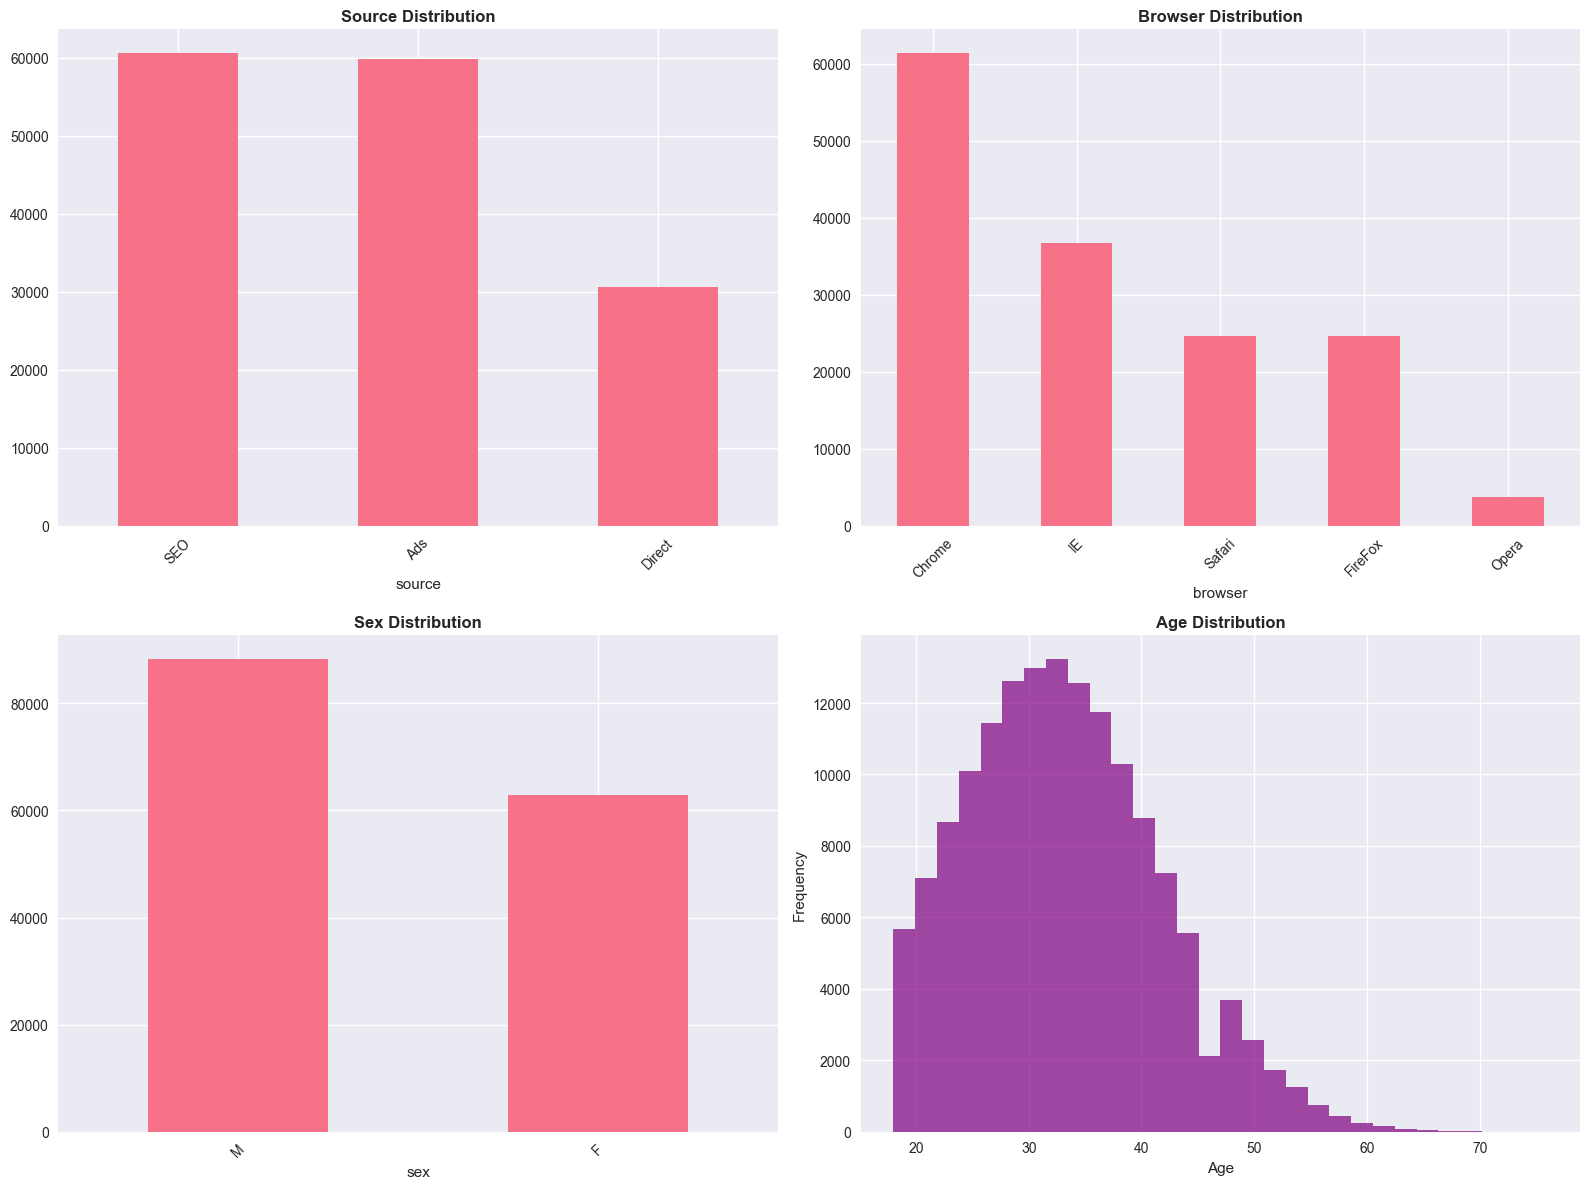

In [6]:
# Categorical features analysis
categorical_features = ['source', 'browser', 'sex']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, feature in enumerate(categorical_features):
    fraud_data[feature].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'{feature.title()} Distribution', fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45)

# Age distribution
fraud_data['age'].hist(bins=30, ax=axes[3], alpha=0.7, color='purple')
axes[3].set_title('Age Distribution', fontweight='bold')
axes[3].set_xlabel('Age')
axes[3].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('../results/fraud_categorical_distributions.png')
plt.show()

In [7]:
# Convert timestamps to datetime
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

# Calculate time_since_signup (in hours)
fraud_data['time_since_signup'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.total_seconds() / 3600

# Extract hour and weekday from purchase_time
fraud_data['purchase_hour'] = fraud_data['purchase_time'].dt.hour
fraud_data['purchase_weekday'] = fraud_data['purchase_time'].dt.weekday

# Display new features
fraud_data[['signup_time', 'purchase_time', 'time_since_signup', 'purchase_hour', 'purchase_weekday']].head()

,signup_time,purchase_time,time_since_signup,purchase_hour,purchase_weekday
0,2015-02-24 22:55:49,2015-04-18 02:47:11,1251.856111,2,5
1,2015-06-07 20:39:50,2015-06-08 01:38:54,4.984444,1,0
2,2015-01-01 18:52:44,2015-01-01 18:52:45,0.000278,18,3
3,2015-04-28 21:13:25,2015-05-04 13:54:50,136.690278,13,0
4,2015-07-21 07:09:52,2015-09-09 18:40:53,1211.516944,18,2


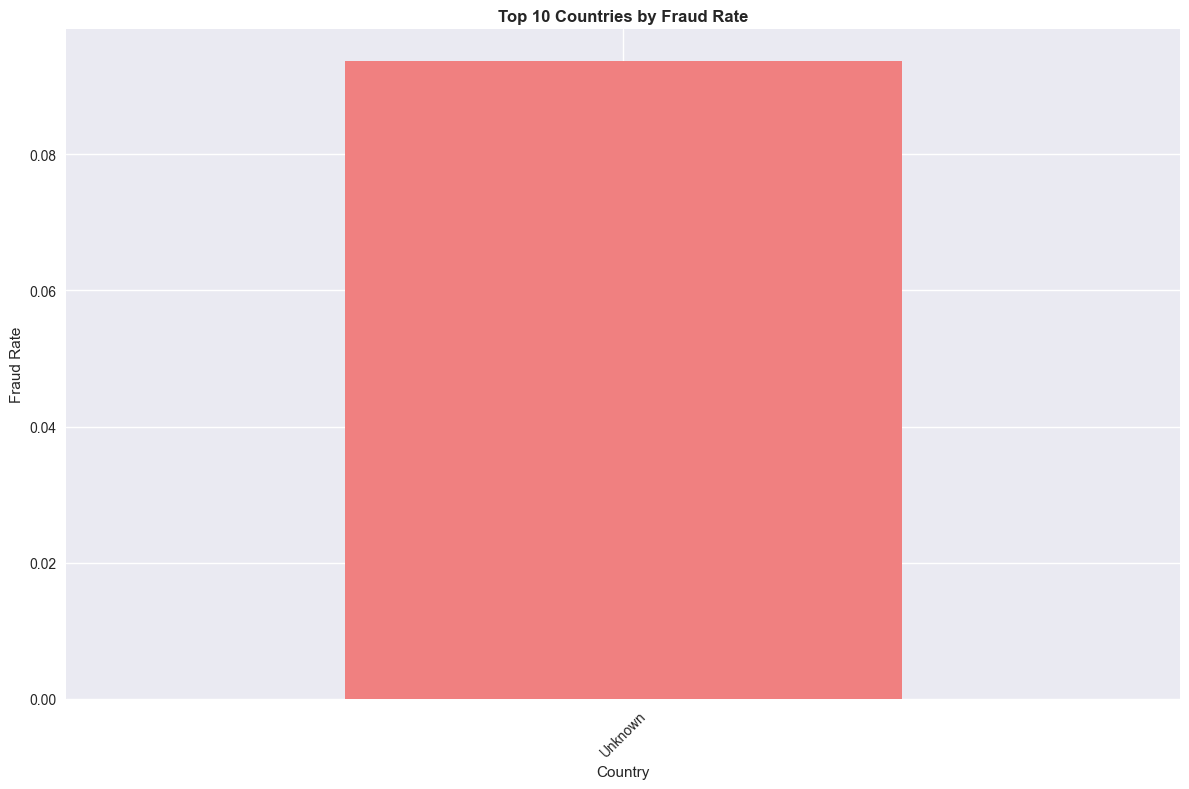

In [8]:
# Function to map IP address to country
def map_ip_to_country(ip, ip_country_df):
    try:
        ip_int = int(ipaddress.ip_address(ip))
        for _, row in ip_country_df.iterrows():
            if row['lower_bound_ip_address'] <= ip_int <= row['upper_bound_ip_address']:
                return row['country']
        return 'Unknown'
    except ValueError:
        return 'Unknown'

# Apply mapping
fraud_data['country'] = fraud_data['ip_address'].apply(map_ip_to_country, args=(ip_country,))

# Visualize top countries by fraud rate
plt.figure(figsize=(12, 8))
country_fraud_rate = fraud_data.groupby('country')['class'].mean().sort_values(ascending=False).head(10)
country_fraud_rate.plot(kind='bar', color='lightcoral')
plt.title('Top 10 Countries by Fraud Rate', fontweight='bold')
plt.xlabel('Country')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../results/country_fraud_rate.png')
plt.show()

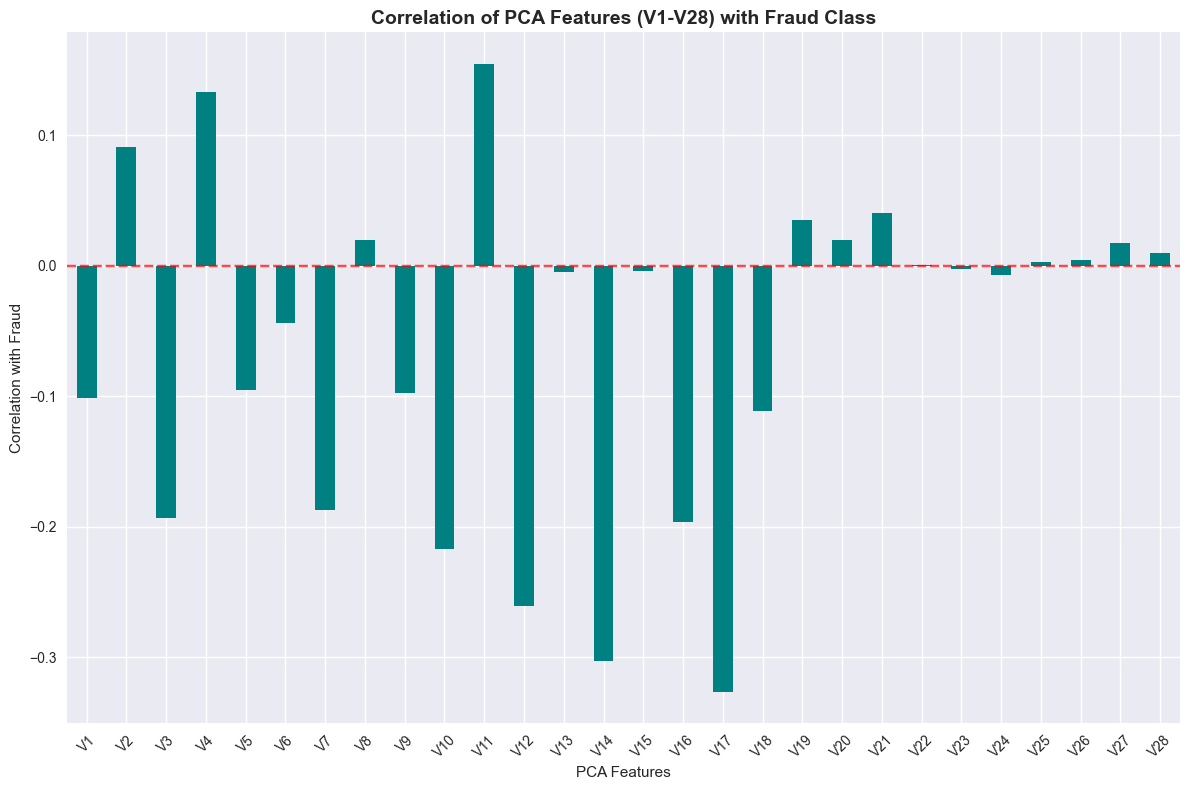

Top 10 PCA features most correlated with fraud:
V17    0.326481
V14    0.302544
V12    0.260593
V10    0.216883
V16    0.196539
V3     0.192961
V7     0.187257
V11    0.154876
V4     0.133447
V18    0.111485
Name: Class, dtype: float64


In [9]:
# Analyze PCA features correlation with fraud
v_features = [col for col in creditcard_data.columns if col.startswith('V')]
correlations = creditcard_data[v_features + ['Class']].corr()['Class'].drop('Class')

# Plot correlation
plt.figure(figsize=(12, 8))
correlations.plot(kind='bar', color='teal')
plt.title('Correlation of PCA Features (V1-V28) with Fraud Class', fontweight='bold', fontsize=14)
plt.xlabel('PCA Features')
plt.ylabel('Correlation with Fraud')
plt.xticks(rotation=45)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('../results/creditcard_pca_correlations.png')
plt.show()

# Show top correlated features
print("Top 10 PCA features most correlated with fraud:")
print(correlations.abs().sort_values(ascending=False).head(10))

In [10]:
cc_class_dist = creditcard_data['Class'].value_counts()

In [11]:
# Save processed insights
import pickle

insights = {
    'fraud_data_shape': fraud_data.shape,
    'creditcard_data_shape': creditcard_data.shape,
    'fraud_imbalance_ratio': fraud_class_dist[0]/fraud_class_dist[1],
    'cc_imbalance_ratio': cc_class_dist[0]/cc_class_dist[1],
    'fraud_class_distribution': fraud_class_dist.to_dict(),
    'cc_class_distribution': cc_class_dist.to_dict(),
    'top_correlated_features': correlations.abs().sort_values(ascending=False).head(10).to_dict(),
    'unique_countries': ip_country['country'].nunique(),
    'categorical_features': categorical_features,
    'country_fraud_rate': country_fraud_rate.to_dict()
}

with open('../results/eda_insights.pkl', 'wb') as f:
    pickle.dump(insights, f)

print("EDA completed and results saved to ../results/ directory")

EDA completed and results saved to ../results/ directory
